In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [20]:
month_to_str = {"01": "JAN", "06": "JUN"}

### Q4

In [2]:
data = pd.read_csv("20250601biddata_genbids.csv")
print(data.shape)
data_cleaned = data[data["Market"] == " DAM"]

/var/folders/h6/k0hvphys1p5b28sdmwwfkh9r0000gn/T/ipykernel_55313/1675447785.py:1: DtypeWarning: Columns (6,12,13,15,27) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("20250601biddata_genbids.csv")


(379610, 59)


#### (a)

In [12]:
def get_bid_stack(df):
    #? Make this more efficient
    qty_price = []
    for i in range(len(df)):
        row = df.iloc[i]
        qty = float(row[f"Dispatch MW1"])
        price = float(row[f"Dispatch $/MW1"])
        qty_price.append([qty, price])
        dp = 2
        while(row[f"Dispatch MW{dp}"].strip() != ""): # value for that dispatch exists
            qty = float(row[f"Dispatch MW{dp}"]) - float(row[f"Dispatch MW{dp-1}"]) # assuming volumes are cumulative
            price = float(row[f"Dispatch $/MW{dp}"])
            qty_price.append([qty, price])
            dp += 1
    # sort in increasing order of prices
    qp_df = pd.DataFrame(qty_price, columns = ["qty", "price"])
    qp_df = qp_df.sort_values(by = "price")
    # then do cumsum over qty
    qp_df["qty_cumsum"] = qp_df["qty"].cumsum()
    return qp_df

def get_day_ahead_clearing_price(data_cleaned, date, time, month = "06", month_str = "JUN", plotting = True):
    temp = data_cleaned[data_cleaned["Date Time"].str.contains(f"{date}{month_str}2025:{time}")] # "16JUN2025:08"
    qp_df = get_bid_stack(temp)
    if(plotting):
        plt.plot(qp_df["qty_cumsum"], qp_df["price"])
    
    data_demand = pd.read_csv(f"2025{month}01isolf_csv/2025{month}{date}isolf.csv")
    data_demand_value = data_demand["NYISO"][int(time)]
    if(plotting):
        plt.axvline(data_demand_value, color = 'r', label = f"Demand Forecast = {data_demand_value} MW")
    # this represents the costliest price at which the buyer would have to buy some of its demand
    data_demand_price = qp_df[qp_df["qty_cumsum"]>=data_demand_value]["price"].iloc[0] 
    
    if(plotting):
        plt.scatter(data_demand_value, data_demand_price, marker = "o", color = 'g', label = f"Clearing price")
        # Annotate with a line pointing to the dot
        plt.annotate(
            f"Clearing Price = ${data_demand_price:.2f}/MWh",
            xy=(data_demand_value, data_demand_price), # point to annotate
            xytext=(data_demand_value-12000, data_demand_price-300), # text location
            arrowprops=dict(arrowstyle="-", color="black"), # simple line
            fontsize=10)
        
        plt.legend()
        plt.xlabel("Cumulative MW (Supply)")
        plt.ylabel("Bid Price ($/MWh)")
        plt.title(f"DAM Supply Bid Stack: 2025-{month}-{date} {time}:00")
        plt.show()

    return data_demand_price


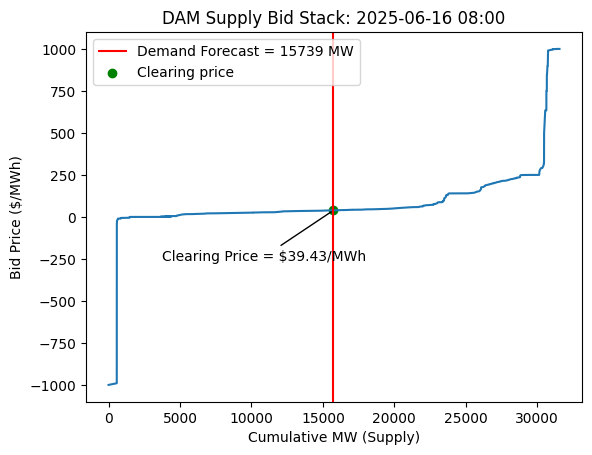

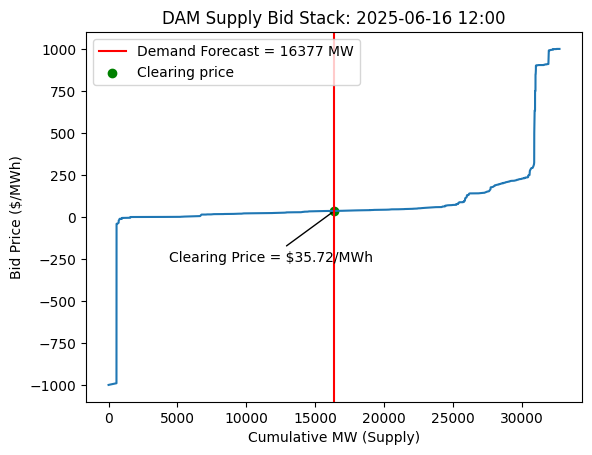

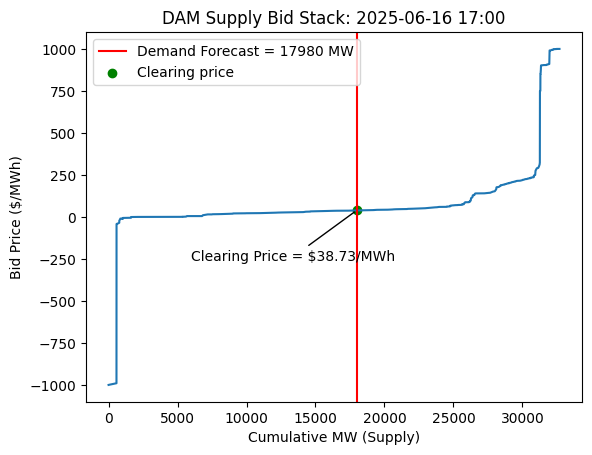

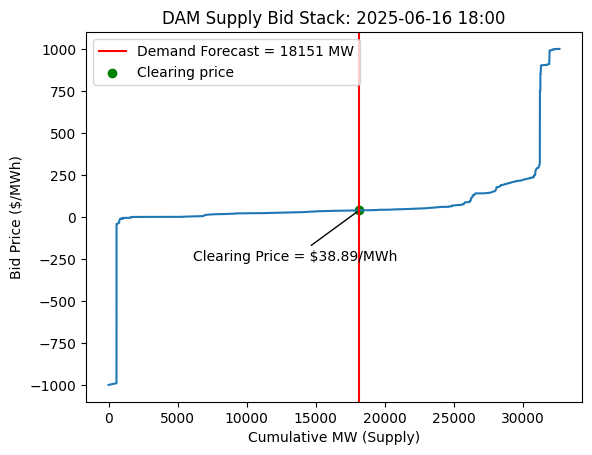

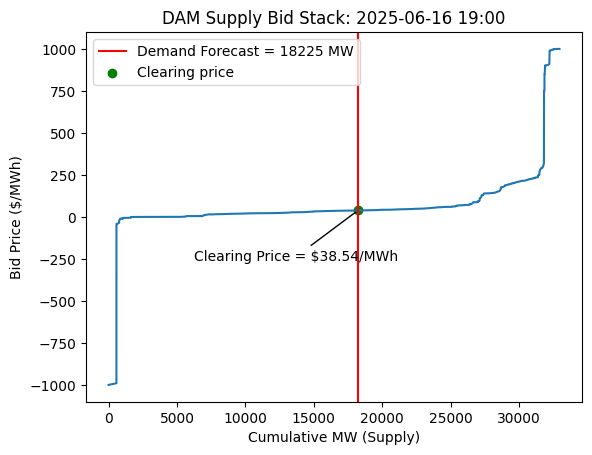

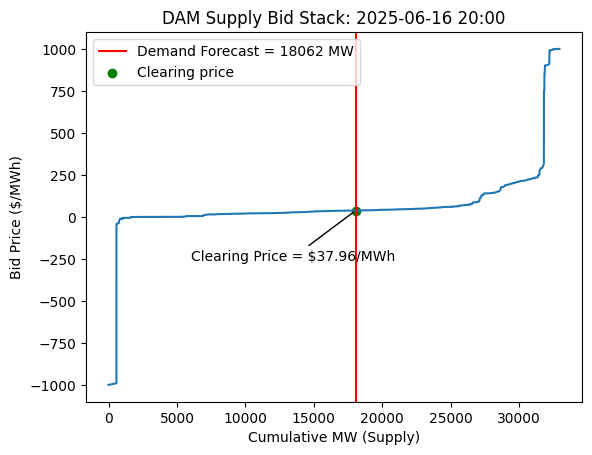

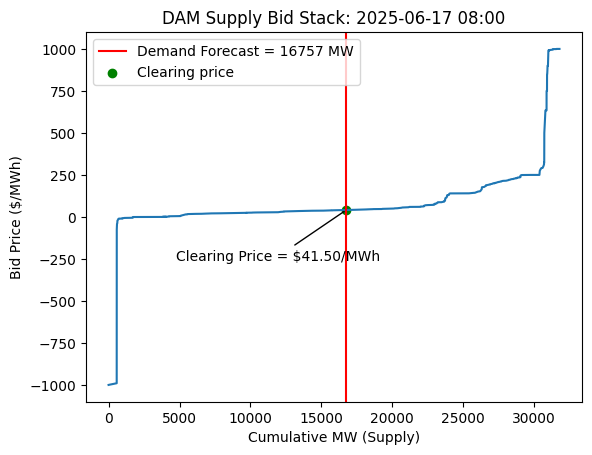

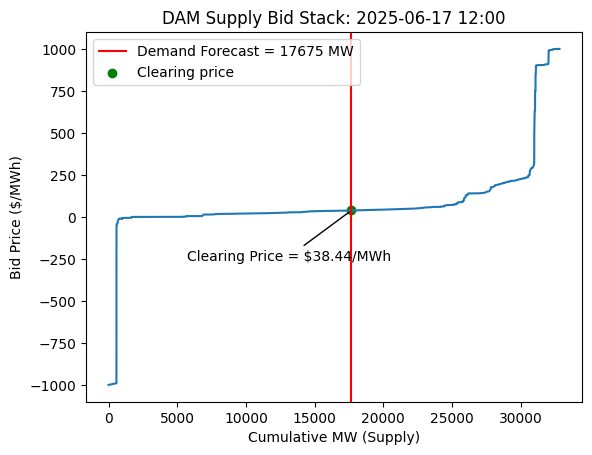

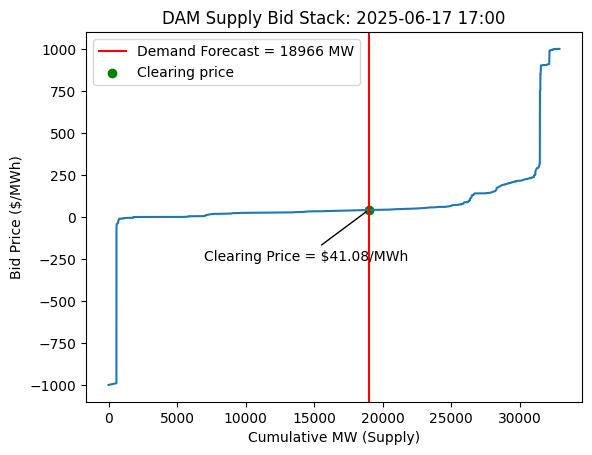

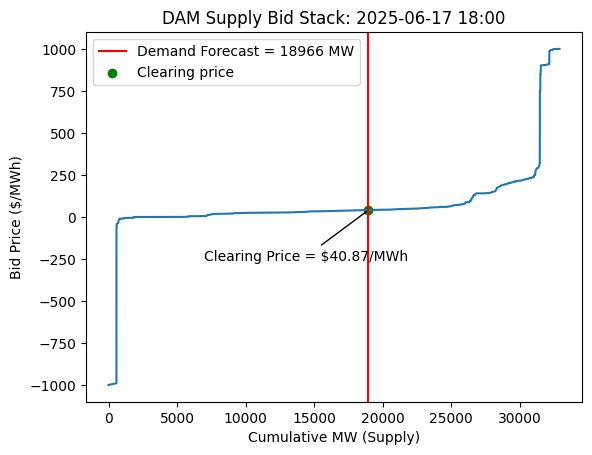

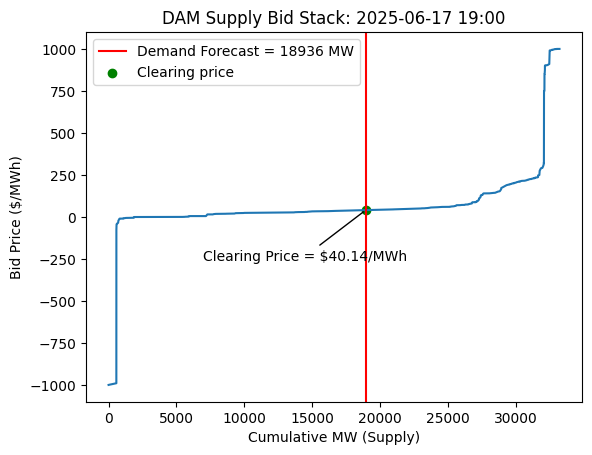

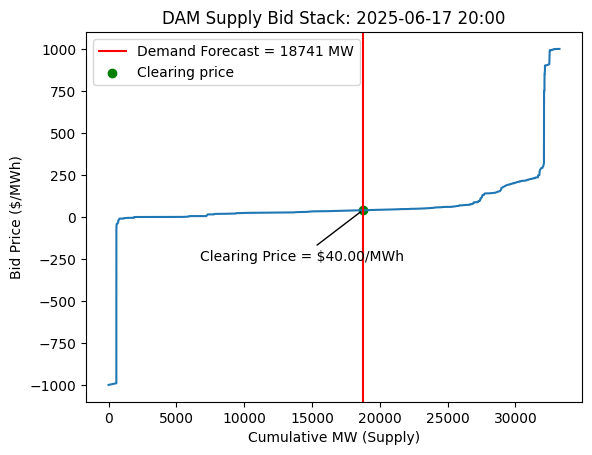

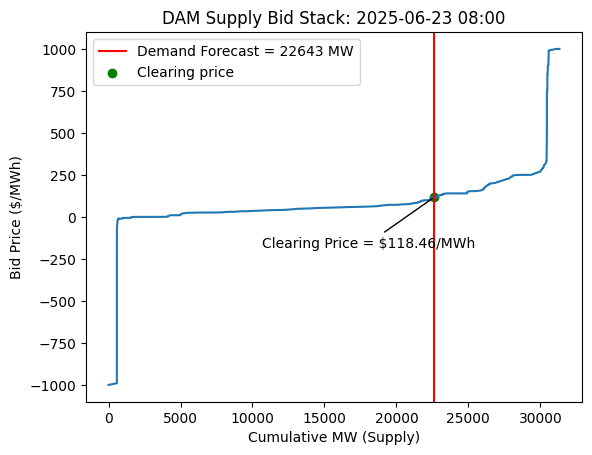

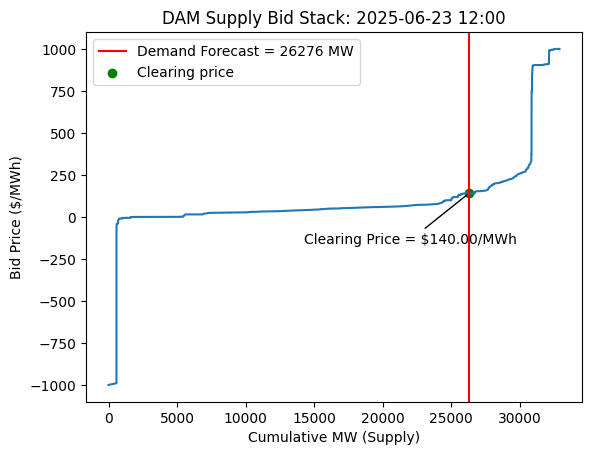

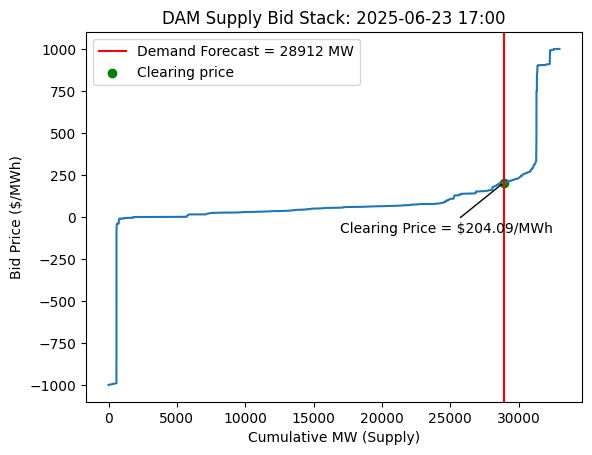

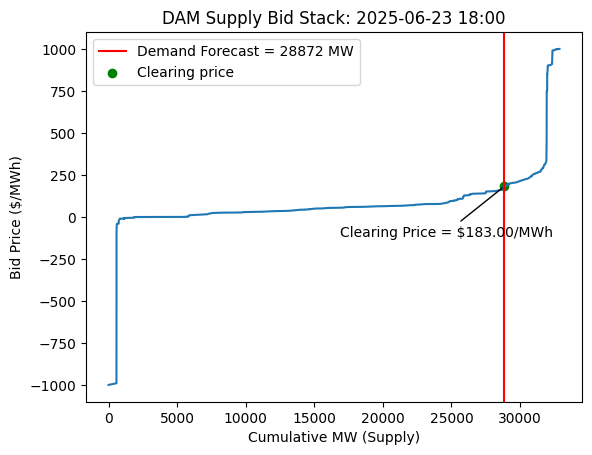

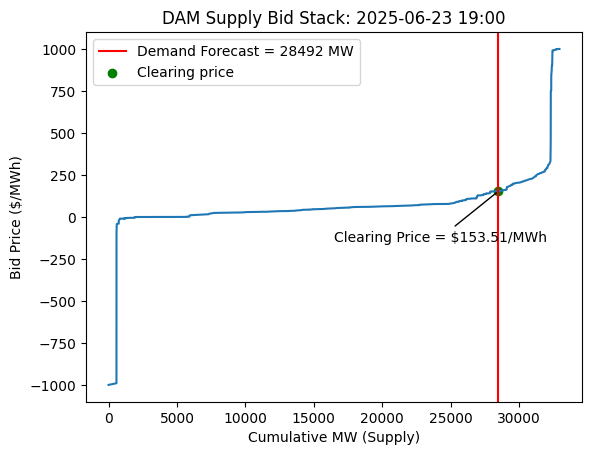

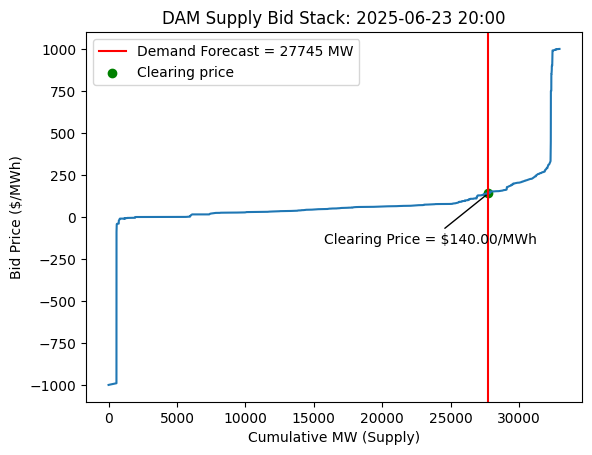

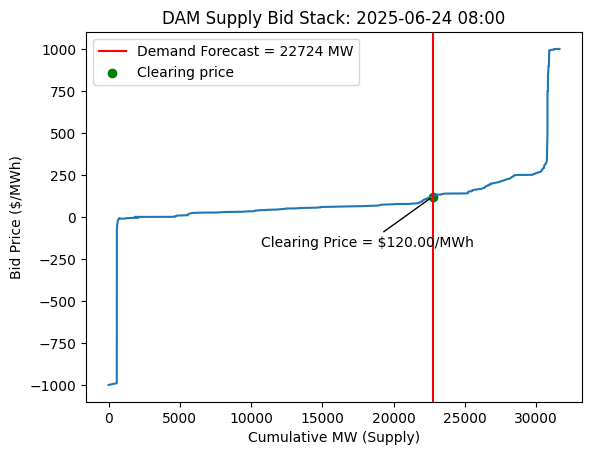

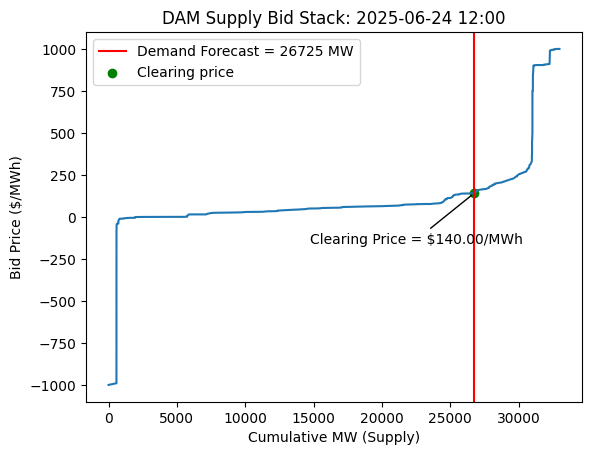

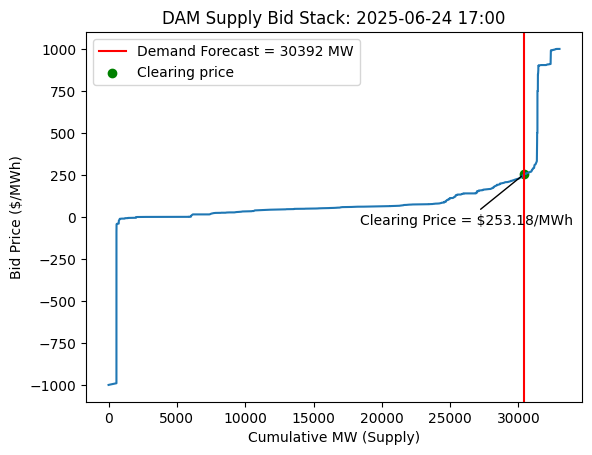

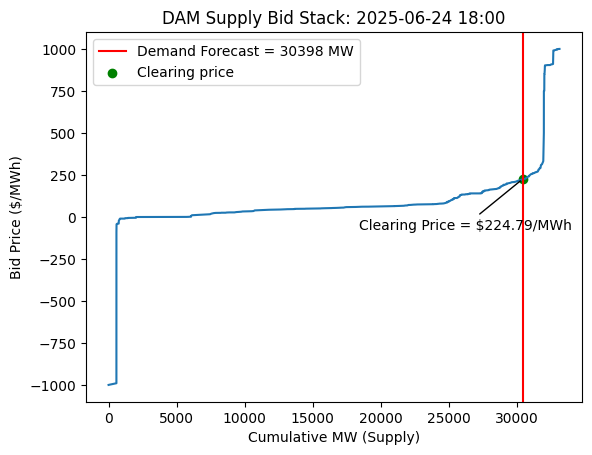

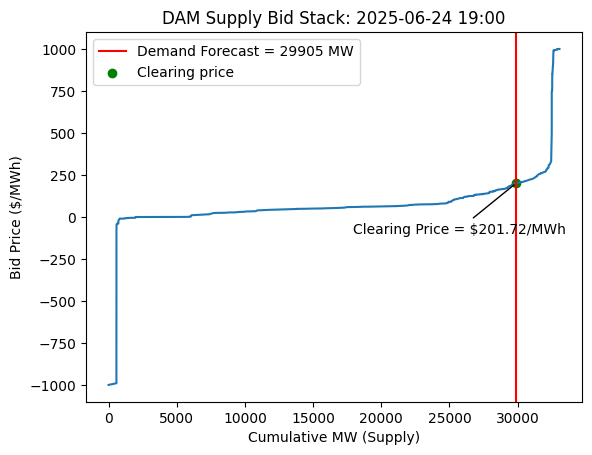

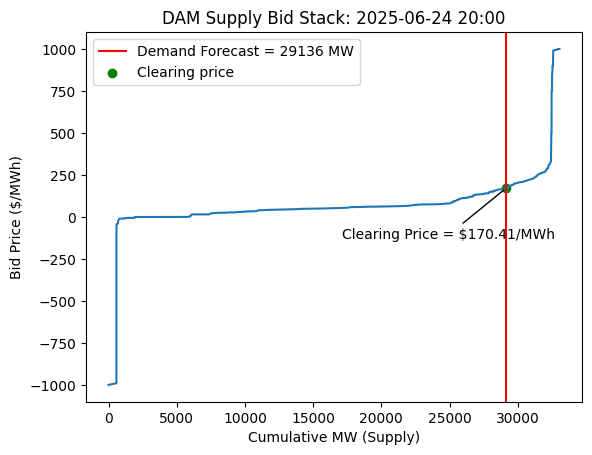

In [13]:
dates = ["16", "17", "23", "24"]
times = ["08", "12", "17", "18", "19", "20"]
data_price = pd.DataFrame(index = dates, columns = times)
for date in dates:
    for time in times:
        data_price.loc[date, time] = get_day_ahead_clearing_price(data_cleaned, date, time)

Clearing prices for various days (index) and various hours (columns)
        08     12      17      18      19      20
16   39.43  35.72   38.73   38.89   38.54   37.96
17    41.5  38.44   41.08   40.87   40.14    40.0
23  118.46  140.0  204.09   183.0  153.51   140.0
24   120.0  140.0  253.18  224.79  201.72  170.41


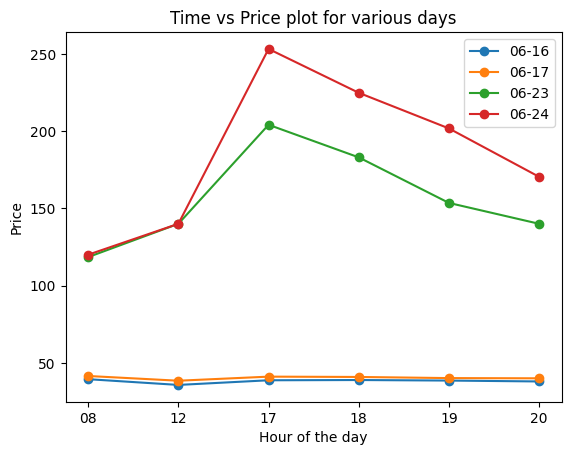

In [14]:
print("Clearing prices for various days (index) and various hours (columns)")
print(data_price)
temp2 = data_price.T
for col in temp2.columns:
    plt.plot(temp2.index, temp2[col], marker = 'o', label = f"06-{col}")
plt.legend()
plt.xlabel("Hour of the day")
plt.ylabel("Price")
plt.title("Time vs Price plot for various days")
plt.show()

#### (b)

#### Narrative
- All the supply and demand data correspond to us working for the day ahead prices (since real time would be observable on the website).
- The demands are the forecasted demands. Hence, the clearing prices that we obtain are the day ahead (DA) prices. As seen, the DA prices are quite high for 23-24 June (2025), indicating that people already predicted for the prices to rise.

- During the heatwave days,
    - The bid stack data tells us that demand forecast rose substantially well which led to a steep increase in the Day Ahead (settlement) price for the heatwave days. So, demand (forecast) seems to have been way more than NY (and PJM) grid could have handled (and/or) anticipated (incorporated in their supply). Hence, the steep increase in price.
    - The NYISO real time load data tells us that real time load was more compared to previous (non-heatwave) days.
    - The fuel mix data tells us that NYISO and PJM were able to produce substantially more on these days compared to previous days. Probably, they did anticipate correctly that a heatwave is going to come and hence demand would increase on these days. So, in effect, NY (and PJM) grid tried to handle the additional load that they anticipated. However, using reference 3, we see that there were indeed some outages in the mid-late evening of 23rd JUN. and almost entire afternoon, early and mid evening of 24th JUN, precisely the period when the price spiked. Thus, this coincidence of power being outed and price spiking may suggest power outage as one of the reasons of the price spike.
    - The DART plot tells us that Real time prices were way more than Day ahead (or predicted) prices indicating that DA prices underpredicted the Real Time prices, indicating that the net day ahead load (or demand) (net means excess demand or demand - supply) forecast underpredicted the net real time load.
    - So, all in all, during the heatwave days, (all real time) demand increased, supply also increased but demand increased more than supply and hence, prices increased.

- Contrasting with Monday and Tuesday of the previous week (16 and 17), 
    - Firstly, there was no heatwave on these days. So, demand ws normal. However, on 23 and 24, there was a heatwave and as per NYISO load data, demand increased. (although heatwave implies more heat implies people would not have moved out implies no cars implies no gas implies less fuel implies demand decreases but demand increases. So, the decreasing effect of not using cars is more than outweighed by the increasing effect of using more ACs and coolants)
    - Now, as per the real time price data, prices also rose during these heatwave days. So, real time prices of 23-24 were much more than the real time prices of 16-17. This indicates that the demand of 23-24 was not completely met, atleast, less fulfilled (by its real time supply) as compared to the demand of 16-17. This indicates that NY (and PJM) grid was not able to handle the demand (using their supply, % wise, % of demand met by supply) during the heatwave (23-24) as good as they were able to handle the demand during the week before i.e. 16-17.
    - Day ahead prices were also higher for 23-24 as compared to 16-17. 
    - The ratio of Real time and Day ahead prices for 23-24 was much more than 1 (that of 16-17). If real time = forecast, this indicates that the prediction is accurate. So, NY (and PJM) grid were able to predict real time prices quite well for 16-17 (non-heatwave days) but not so well (underprediction) for 23-24 (heatwave days). So, both underprediction of real time prices and increase in day ahead prices (compared to 16-17) indicates that NY (and PJM) grid were not able to handle the increased net demand during the heatwave.

- Note that price inc does not imply demand inc and vice versa. However, price inc does imply demand - supply inc and vice versa.

- Regarding the price spikes in the real time data,
    - On 23rd June, from 5 to 10 PM, the real time prices were quite high. Essentially, there was a spike around 6, 7 and 7:30 PM and hence, price was high for all of the early evening.
    - Same is the story for 24th June. The price was quite high form 2 to 9 PM on this day. There was a small spike around 2 followed by large spikes around 4, 5, 5:45 and 6:30-6:45 PM (again early evening filled with spikes).

- What caused them?
    - Mostly, the super increase in the demand and not so much increase in the supply (hence, super increase in net demand) caused these spikes. 
    - Grid strain due to power outages and hence, reserves (or the supply) dropping, also explains the spikes.
    - Transmission line congestion in NYC also reinforces the same.
    - Activating emergency supplies to fulfil the demand could also have caused steep increase in prices, especially during late evenings when sun/solar energy would not have been that prominent.

#### Plotting Real Time Prices

In [76]:
# Finding DA and RT prices for each hour of each of the 4 days (RT referred from Time-Weighted/Integrated Real Time Market Price from MIS.NYISO.COM)
month = "06" 
month_str = month_to_str[month]
dates = ["16", "17", "23", "24"]
times = [str(i).zfill(2) for i in range(0, 24)]
price_da_mine = pd.DataFrame(index = dates, columns = times)
price_da_file = pd.DataFrame(index = dates, columns = times)
price_rt = pd.DataFrame(index = dates, columns = times)
for date in dates: 
    data_da = pd.read_csv(f"2025{month}01damlbmp_zone_csv/2025{month}{date}damlbmp_zone.csv")
    data_rt = pd.read_csv(f"2025{month}01rtlbmp_zone_csv/2025{month}{date}rtlbmp_zone.csv")
    for time in times:
        price_da_mine.loc[date, time] = get_day_ahead_clearing_price(data_cleaned, date, time, month = month, month_str = month_str, plotting = False)
        price_da_file.loc[date, time] = data_da[(data_da["Name"] == "N.Y.C.") & (data_da["Time Stamp"] == f"{month}/{date}/2025 {time}:00")]["LBMP ($/MWHr)"].iloc[0]
        price_rt.loc[date, time] = data_rt[(data_rt["Name"] == "N.Y.C.") & (data_rt["Time Stamp"] == f"{month}/{date}/2025 {time}:00")]["LBMP ($/MWHr)"].iloc[0]

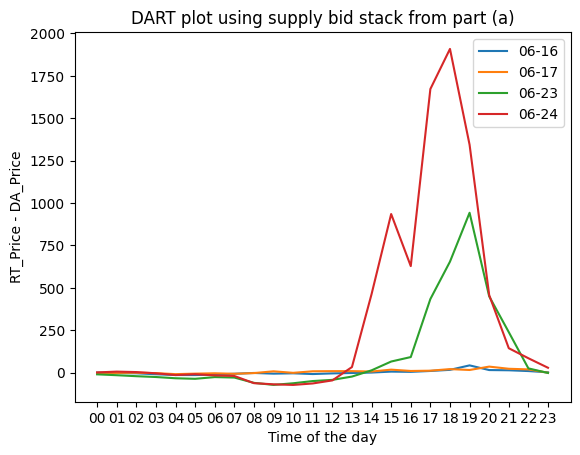

In [80]:
for date in dates:
    v = price_rt.loc[date] - price_da_mine.loc[date]
    plt.plot(times, v, label = f"{month}-{date}")
plt.legend()
plt.xlabel("Time of the day")
plt.ylabel("RT_Price - DA_Price")
plt.title("DART plot using supply bid stack from part (a)")
plt.show()

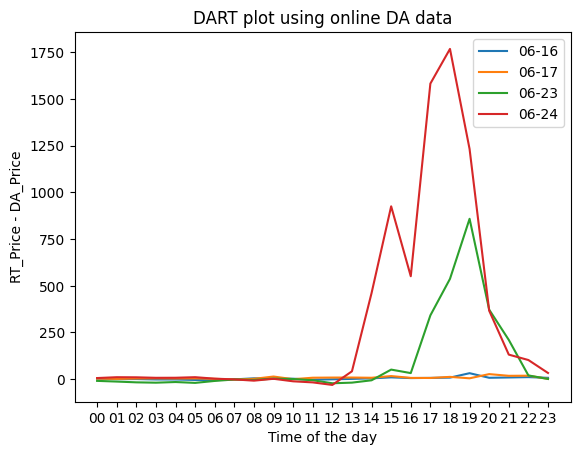

In [81]:
for date in dates:
    v = price_rt.loc[date] - price_da_file.loc[date]
    plt.plot(times, v, label = f"{month}-{date}")
plt.legend()
plt.xlabel("Time of the day")
plt.ylabel("RT_Price - DA_Price")
plt.title("DART plot using online DA data")
plt.show()

In [83]:
print(price_da_mine.T)

       16     17      23      24
00  31.61  33.32    63.0    68.0
01  28.27  28.73    60.8    65.0
02  27.78  27.78   60.43   64.45
03   30.1  29.48    60.0    64.0
04  34.73  35.33   68.58   73.48
05   35.5  36.45   70.45   74.71
06  36.59  37.48   73.63   76.79
07  38.54  40.13   87.51   80.23
08  39.43   41.5  118.46   120.0
09  39.43  41.91   140.0   140.0
10  36.24  38.57   140.0   140.0
11  35.72  37.96  130.86   140.0
12  35.72  38.44   140.0   140.0
13  35.81  38.68  152.98  165.81
14  36.99  39.45  155.29  187.59
15  37.02  39.79  187.59  209.41
16  37.55  40.19  195.37   223.0
17  38.73  41.08  204.09  253.18
18  38.89  40.87   183.0  224.79
19  38.54  40.14  153.51  201.72
20  37.96   40.0   140.0  170.41
21  37.21  38.86   110.0   153.0
22  36.67  37.11   79.03  120.43
23  34.89   35.0   74.51    80.0


In [84]:
print(price_da_file.T)

       16     17      23      24
00  28.91  28.75   62.11   63.38
01  25.89  25.87   58.47   60.52
02  23.34  23.79   56.45   57.91
03  22.16  22.23   53.01   52.81
04   22.4  22.74   50.76   51.67
05  25.49  26.31   53.91   54.78
06  30.78  31.78   56.77   57.91
07  32.98  35.45   60.24   61.84
08   33.0  37.04   62.25   65.95
09  30.84  35.62   64.99   69.09
10   30.0  37.52   76.47   79.03
11  30.25  38.18   86.96   93.48
12  31.99  38.65  119.35   125.0
13  32.15  38.74  148.32  156.54
14  33.08  38.47  174.85  189.33
15   33.4  40.83  201.85   219.0
16  36.33  43.28  254.68   300.0
17   41.8  46.22  296.43  342.72
18  46.99  49.44   300.2   365.0
19  49.34  51.17  237.37  313.07
20  45.79  48.42  217.69  260.95
21  41.98  43.74   138.5  165.53
22  35.02  37.67   83.98  102.73
23  29.59  32.75   71.58   75.56


#### References:
1.  https://www.gridstatus.io/live/nyiso?date=2025-06-23
2. https://www.gridstatus.io/live/nyiso?date=2025-06-24
3. https://mis.nyiso.com/public/ (Power Grid Data/Outages/Real Time Actual Outages/06-2025/)
4. https://www.joinarbor.com/resources/electricity-prices-hit-3-000-mwh-this-week-thats-as-insane-as-it-sounds
5. https://www.pcienergysolutions.com/2023/10/18/day-ahead-vs-real-time-market-whats-the-difference/